In [2]:
import tensorflow as tf
from utils.distributions import Gaussian, gen_ring, GMM
from utils.dynamics import Dynamics

%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def tf_accept(x, Lx, px):
    mask = (px - tf.random_uniform(tf.shape(px)) >= 0.)
    return tf.where(mask, Lx, x)

gaussian1 = Gaussian(mu=np.zeros((2,)), sigma=np.eye(2,))
gaussian2 = Gaussian(mu=np.ones((2,)), sigma=np.array([[1.0, 0.95], [0.95, 1.0]]))
n_samples = 1000
init_energy = gaussian1.get_energy_function()
final_energy = gaussian2.get_energy_function()
beta_diff = 0.0001

def body(z, w, t):
    curr_beta = (t) * beta_diff
    curr_energy = lambda z: (1-curr_beta) * init_energy(z) + (curr_beta) * final_energy(z)
    diff_energy = - final_energy(z) + init_energy(z)
    w = w + beta_diff * diff_energy
    dynamics = Dynamics(x_dim=2, energy_function=curr_energy, eps=0.5, hmc=True, T=25)
    
    new_z, _, p = dynamics.forward(z)
    mh_z = tf_accept(z, new_z, p)
    
    return mh_z, w, t+1

def cond(z, w, t):
    return tf.less(t, 10000+1)

start_z, start_w, start_t = tf.random_uniform((n_samples, 2)), tf.zeros((n_samples,)), tf.constant(0.)

last_z, last_w, T = tf.while_loop(body=body, cond=cond, loop_vars=(tf.random_normal((20, 2)), tf.zeros((20,)), tf.constant(0.)))

In [ ]:
with tf.Session() as sess:
    log_w_T = sess.run(last_w)

In [29]:
def get_log_Z(sigma):
    n = sigma.shape[0]
    return 0.5 * np.log(np.linalg.det(2 * np.pi * sigma))
    

In [ ]:
Z_1 = get_log_Z(np.eye(2,))

In [ ]:
Z_T = get_log_Z(np.array([[1.0, 0.95], [0.95, 1.0]]))

In [ ]:
from scipy.misc import logsumexp

In [ ]:
  beta = tf.linspace(0., 1., n_samples+1)[1:]
  beta_diff = beta[1] - beta[0]
  def body(a, beta):
    def log_prob_beta(x, beta, *args, **kwargs):
      return (1-beta) * log_q_f(x, *args, **kwargs) + beta * log_prob_f(x, *args, **kwargs)
    last_x = a[1]
    w = a[2]
    w = w + beta_diff * (log_prob_f(last_x, *args, **kwargs)
                         - log_q_f(last_x, *args, **kwargs))
    alpha, updated_x = hmc_kernel(step_size, lf_steps, last_x, log_prob_beta,
                                  beta, *args, **kwargs)
    alpha.set_shape(batch_size)
    updated_x.set_shape(z_shape)
    return (alpha, updated_x, w)

  alpha, x, w = tf.scan(body, beta, (tf.zeros_like(initial_x[:, 0]),
                        initial_x, tf.zeros_like(initial_x[:, 0])))
  return alpha[-1], x[-1], w[-1]

In [ ]:
logsumexp(log_w_T) - np.log(20)

In [ ]:
S1 = np.random.randn(5, 5)
S2 = np.random.randn(5, 5)

mu1 = np.random.randn(5)
mu2 = np.random.randn(5)

sigma1 = S1.dot(S1.T) + 0.1 * np.eye(5)
sigma2 = S2.dot(S2.T) + 0.1 * np.eye(5)

gaussian1 = Gaussian(mu=np.zeros(5,), sigma=np.eye(5))
gaussian2 = Gaussian(mu=mu2, sigma=sigma2)

init_energy = gaussian1.get_energy_function()
final_energy = gaussian2.get_energy_function()

beta = tf.linspace(0., 1., 500+1)[1:]
beta_diff = beta[1] - beta[0]

def body(a, beta):
    curr_energy = lambda z: (1-beta) * init_energy(z) + (beta) * final_energy(z)
    last_x = a[1]
    w = a[2]
    w = w + beta_diff * (- final_energy(last_x) + init_energy(last_x))
    dynamics = Dynamics(x_dim=5, energy_function=curr_energy, eps=0.5, hmc=True, T=25)
    Lx, _, px = dynamics.forward(last_x)
    updated_x = tf_accept(last_x, Lx, px)
    return (px, updated_x, w)


alpha, x, w = tf.scan(body, beta, (tf.zeros_like(initial_x[:, 0]),
                    initial_x, tf.zeros_like(initial_x[:, 0])))

In [13]:
with tf.Session() as sess:
    Z_hat = sess.run(log_w_T)

In [16]:
get_log_Z(np.eye(5)) - get_log_Z(sigma2)

-2.4374052675115792

In [ ]:
logsumexp(log_w_T) - np.log(100)

In [3]:
from utils.ais import ais_estimate

In [11]:
log_w_T = ais_estimate(init_energy, final_energy, 500, initial_x, step_size=1., x_dim=5)

In [5]:
S1 = np.random.randn(5, 5)
S2 = np.random.randn(5, 5)

mu1 = np.random.randn(5)
mu2 = np.random.randn(5)

sigma1 = S1.dot(S1.T) + 0.1 * np.eye(5)
sigma2 = S2.dot(S2.T) + 0.1 * np.eye(5)

gaussian1 = Gaussian(mu=np.zeros(5,), sigma=np.eye(5))
gaussian2 = Gaussian(mu=mu2, sigma=sigma2)

init_energy = gaussian1.get_energy_function()
final_energy = gaussian2.get_energy_function()

In [7]:
initial_x = tf.random_normal((100, 5))


In [17]:
print Z_hat

2.37838


In [16]:
x = tf.placeholder(tf.float32, shape=(None,))

In [17]:
y = tf.split(x, 5, axis=0)

In [5]:
y

[<tf.Tensor 'split:0' shape=(?, 5) dtype=float32>,
 <tf.Tensor 'split:1' shape=(?, 5) dtype=float32>,
 <tf.Tensor 'split:2' shape=(?, 5) dtype=float32>,
 <tf.Tensor 'split:3' shape=(?, 5) dtype=float32>,
 <tf.Tensor 'split:4' shape=(?, 5) dtype=float32>]

In [22]:
z = tf.stack(map(tf.reduce_sum, y), axis=0)

In [23]:
with tf.Session() as sess:
    print sess.run([x, y, z], {x: np.random.randn(5)})

[array([-0.2261681 ,  1.4126395 ,  0.32280308,  0.89244515, -1.3002491 ], dtype=float32), [array([-0.2261681], dtype=float32), array([ 1.4126395], dtype=float32), array([ 0.32280308], dtype=float32), array([ 0.89244515], dtype=float32), array([-1.3002491], dtype=float32)], array([-0.2261681 ,  1.4126395 ,  0.32280308,  0.89244515, -1.3002491 ], dtype=float32)]


In [ ]:
xrange()

In [11]:
x = np.random.randn(100, 5)

for i in xrange(0, 100, 10):
    ais_batch = x[i:i+10]
    ais_batch = ais_batch[:, np.newaxis, :] + np.zeros([1, 5, 1])
    ais_batch = np.reshape(ais_batch, [-1, 5])
    
    print ais_batch

[[ 0.38325283 -0.96053689  2.81613453  0.95168339  1.41924882]
 [ 0.38325283 -0.96053689  2.81613453  0.95168339  1.41924882]
 [ 0.38325283 -0.96053689  2.81613453  0.95168339  1.41924882]
 [ 0.38325283 -0.96053689  2.81613453  0.95168339  1.41924882]
 [ 0.38325283 -0.96053689  2.81613453  0.95168339  1.41924882]
 [-0.20761181 -1.21944647 -1.46481894 -0.29245797  0.77964475]
 [-0.20761181 -1.21944647 -1.46481894 -0.29245797  0.77964475]
 [-0.20761181 -1.21944647 -1.46481894 -0.29245797  0.77964475]
 [-0.20761181 -1.21944647 -1.46481894 -0.29245797  0.77964475]
 [-0.20761181 -1.21944647 -1.46481894 -0.29245797  0.77964475]
 [ 1.07310594  1.25099697  1.19285042 -0.91344287  0.77140126]
 [ 1.07310594  1.25099697  1.19285042 -0.91344287  0.77140126]
 [ 1.07310594  1.25099697  1.19285042 -0.91344287  0.77140126]
 [ 1.07310594  1.25099697  1.19285042 -0.91344287  0.77140126]
 [ 1.07310594  1.25099697  1.19285042 -0.91344287  0.77140126]
 [-0.79463392  1.91218611 -0.80887158  0.12448244 -0.61

In [15]:
print [i for i in xrange(0, 10, 2)]

[0, 2, 4, 6, 8]


In [25]:
tf.no_op()

<tf.Operation 'NoOp' type=NoOp>

In [28]:
np.exp(0.1 * np.log(0.5) / (0.5 * 25.))

0.99447016867321436

In [30]:
get_log_Z(np.eye(50,))

45.946926660233672

In [31]:
from utils.func_utils import get_data, binarize

In [32]:
train, test = get_data()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [89]:
train = binarize(train)

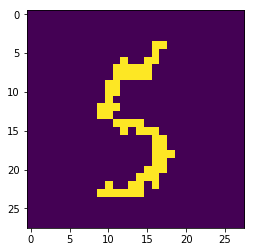

In [96]:
plt.imshow(np.reshape(x[5], (28, 28)))

In [90]:
np.random.shuffle(train)

In [46]:
test_small = test[:200]

In [47]:
test_small.shape

(200, 784)

In [92]:
np.save('train_small', train[:200])

In [95]:
x = np.load('train_small.npy')

In [50]:
x


array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

In [52]:
-17720.4316406 / 200

-88.602158203

In [53]:
-17392.8193359 / 200

-86.9640966795

In [54]:
np.exp(0.1 * np.log(0.5))

0.93303299153680741

In [55]:
-17343.2724609 / 200

-86.7163623045

In [56]:
-18505 / 200

-93

In [62]:
-19975.2060547 / 200

-99.8760302735

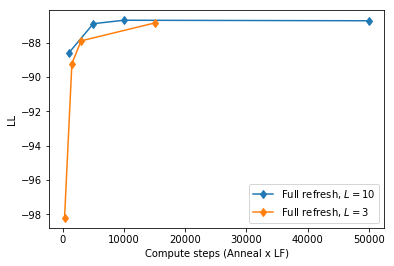

In [87]:
full = [-88.6, -86.9, -86.7, -86.73]
partial = [-93., -99.88, -108.36, -140]
full2 = [-98.2, -89.22, -87.9, -86.86]
x = [100, 500, 1000]
plt.plot([1000, 5000, 10000, 50000], full, marker='d', label='Full refresh, $L=10$')
#plt.plot([1000, 5000, 10000, 50000], partial, marker='d', label='Partial refresh, equiv $L=10$')
plt.plot([300, 1500, 3000, 15000], full2, marker='d', label='Full refresh, $L=3$')
plt.xlabel('Compute steps (Anneal x LF)')
plt.ylabel('LL')
plt.legend()


In [64]:
-19638.1513672 / 200

-98.190756836

In [73]:
-17588.3432617 / 200

-87.9417163085

In [80]:
-17347.1787109 / 200

-86.7358935545

In [88]:
-17405.16015628 / 200

-87.0258007814

In [6]:
LFs = [2, 5, 10]
MHs = [2, 5, 10]
HMC = [True, False]
nb_gpus = 4
from itertools import product

In [27]:
cmd = 'python mnist_vae.py --hparams "batch_size=512,epoch=300,leapfrogs=%d,MH=%d,hmc=%s"'

workers = [[] for i in range(nb_gpus)]
jobs = []
for LF, MH, is_HMC in product(LFs, MHs, HMC):
    jobs.append(cmd % (LF, MH, is_HMC))

In [28]:
from random import shuffle

In [29]:
shuffle(jobs)

for i, job in enumerate(jobs):
    workers[i % nb_gpus].append('CUDA_VISIBLE_DEVICES=%d %s' % (i % nb_gpus, job))

In [30]:
workers[0]

['CUDA_VISIBLE_DEVICES=0 python mnist_vae.py --hparams "batch_size=512,epoch=300,leapfrogs=10,MH=2,hmc=False"',
 'CUDA_VISIBLE_DEVICES=0 python mnist_vae.py --hparams "batch_size=512,epoch=300,leapfrogs=5,MH=10,hmc=False"',
 'CUDA_VISIBLE_DEVICES=0 python mnist_vae.py --hparams "batch_size=512,epoch=300,leapfrogs=2,MH=5,hmc=False"',
 'CUDA_VISIBLE_DEVICES=0 python mnist_vae.py --hparams "batch_size=512,epoch=300,leapfrogs=5,MH=2,hmc=False"',
 'CUDA_VISIBLE_DEVICES=0 python mnist_vae.py --hparams "batch_size=512,epoch=300,leapfrogs=10,MH=10,hmc=False"']

In [31]:
for i, worker in enumerate(workers):
    with open('gpu%d.sh' % i, 'w') as f:
        for task in worker:
            f.write(task+'\n')